In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.shape

(1460, 81)

In [5]:
test.shape

(1459, 80)

## Data preprocessing
* First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal
* Create Dummy variables for the categorical features
* Replace the numeric missing values (NaN's) with the mean of their respective columns

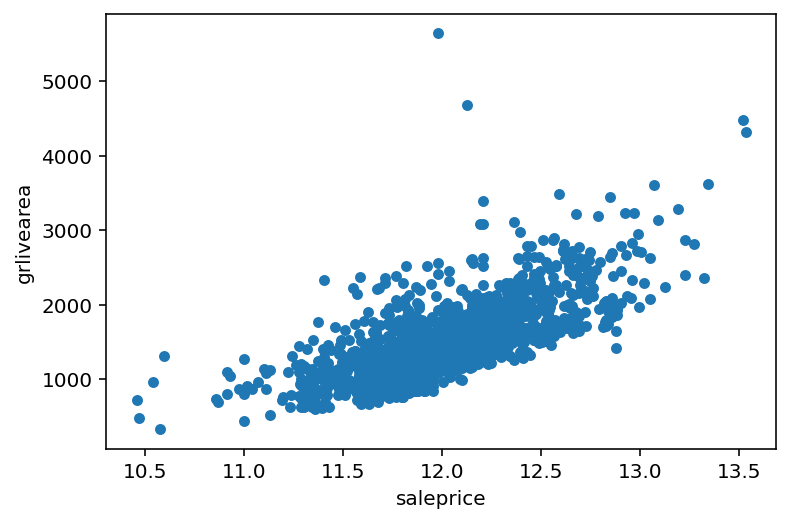

In [221]:
t = pd.DataFrame({'saleprice': y, 'grlivearea': train['GrLivArea']})
t.plot(x='saleprice', y='grlivearea', kind='scatter')

In [228]:
train = train[train['GrLivArea']<4500]

df = pd.concat([train.loc[:, 'MSSubClass':'SaleCondition']
                , test.loc[:, 'MSSubClass':'SaleCondition']], axis=0)
# df.reset_index(drop=True, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026D7817C760>,
      dtype=object)

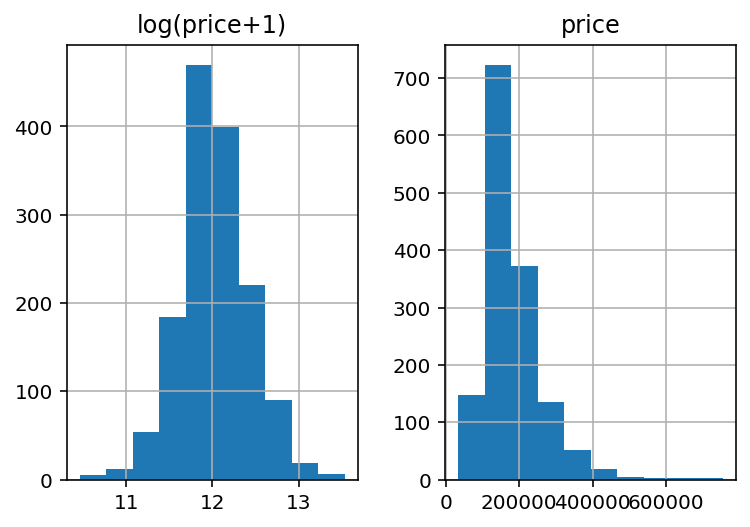

In [230]:
prices = pd.DataFrame({'price': train['SalePrice'], 'log(price+1)': np.log1p(train['SalePrice'])})
prices.hist()

In [231]:
train['SalePrice'] = np.log1p(train['SalePrice'])

In [232]:
numeric_feats = df.dtypes[df.dtypes != 'object'].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
df[skewed_feats] = np.log1p(df[skewed_feats])

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [234]:
df_ = pd.get_dummies(df)
df_ = df_.fillna(df_.mean())

In [236]:
X_train = df_[:train.shape[0]]
X_test = df_[train.shape[0]:]
y = train.SalePrice

## Models
Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

In [238]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv=5))
    return rmse

In [239]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [240]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index=alphas)

Text(0, 0.5, 'rmse')

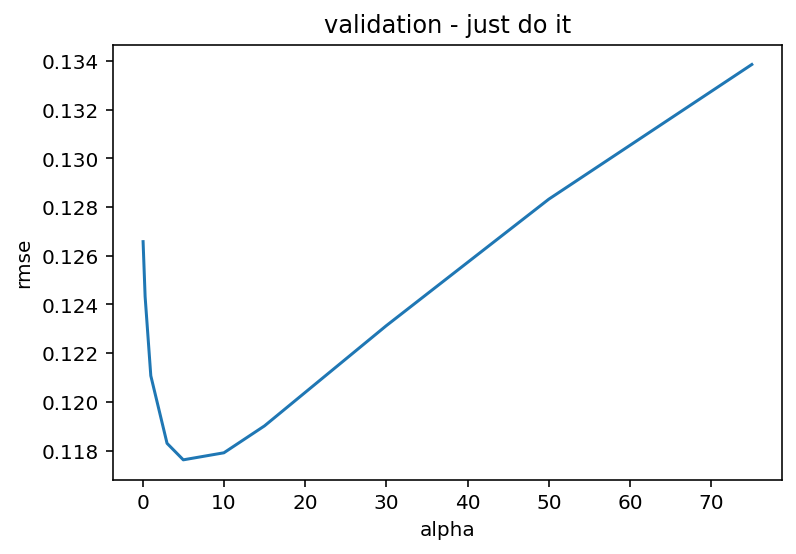

In [241]:
cv_ridge.plot(title='validation - just do it')
plt.xlabel('alpha')
plt.ylabel('rmse')

In [256]:
cv_ridge.min()

0.11761875767708756

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

In [242]:
# Lasso model 
model_lasso = LassoCV(alphas=[1, 0.1, 0.001, 0.0005]).fit(X_train, y)
model_lasso

LassoCV(alphas=[1, 0.1, 0.001, 0.0005])

In [243]:
rmse_cv(model_lasso).mean()

0.11479052635249262

In [257]:
rmse_cv(model_lasso).min()

0.1062234864523574

Nice! The lasso performs even better so we'll just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [244]:
coef = pd.Series(model_lasso.coef_, index=X_train.columns)
print("lasso picked: " + str(sum(coef!=0)))
print("lasso eliminated: " + str(sum(coef==0)))

lasso picked: 113
lasso eliminated: 174


Good job Lasso. One thing to note here however is that the features selected are not necessarily the "correct" ones - especially since there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most important coefficients are:

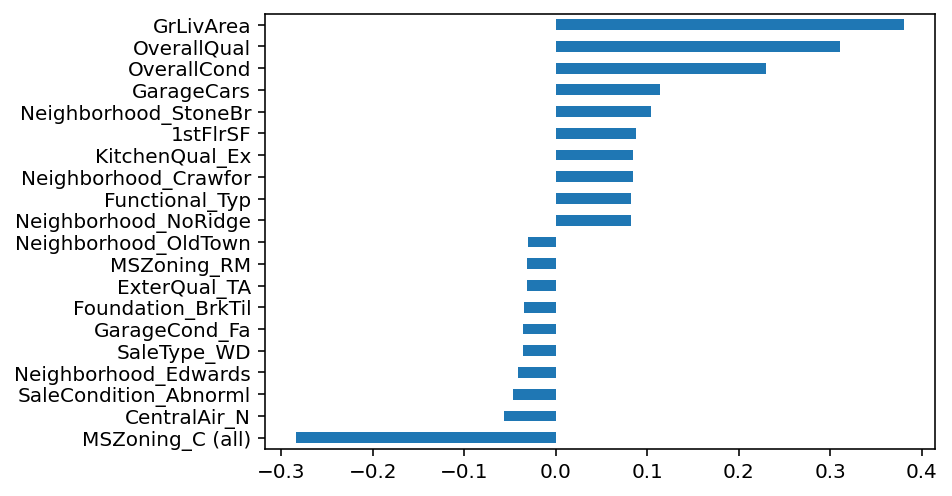

In [245]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
imp_coef.plot.barh()

The most important positive feature is GrLivArea - the above ground area by area square feet. This definitely sense. Then a few other location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

Also note that unlike the feature importance you'd get from a random forest these are actual coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret.

In [246]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

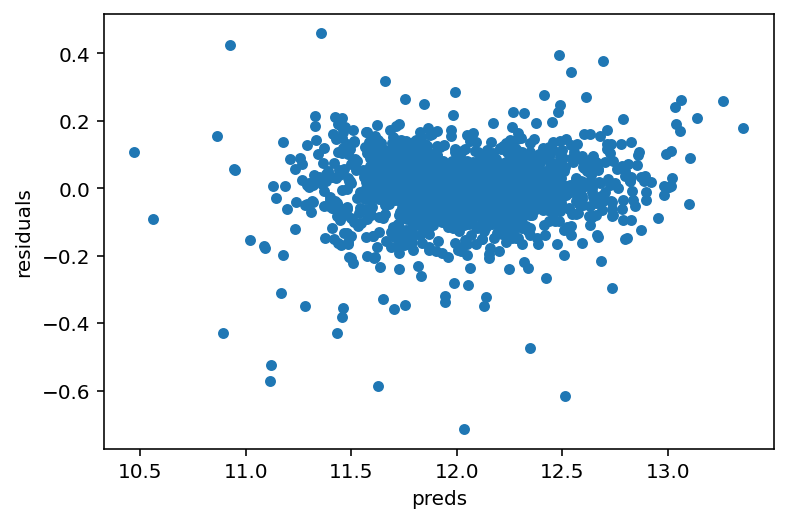

In [247]:
preds = pd.DataFrame({'preds': model_lasso.predict(X_train), 'True': y})
preds['residuals'] = preds['True'] - preds['preds']
preds.plot(x='preds', y='residuals', kind='scatter')

The residual plot looks pretty good.To wrap it up let's predict on the test set and submit on the leaderboard:

In [248]:
# xgboost 
import xgboost as xgb 

dtrain = xgb.DMatrix(X_train, label=y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth": 2, "eta": 0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)

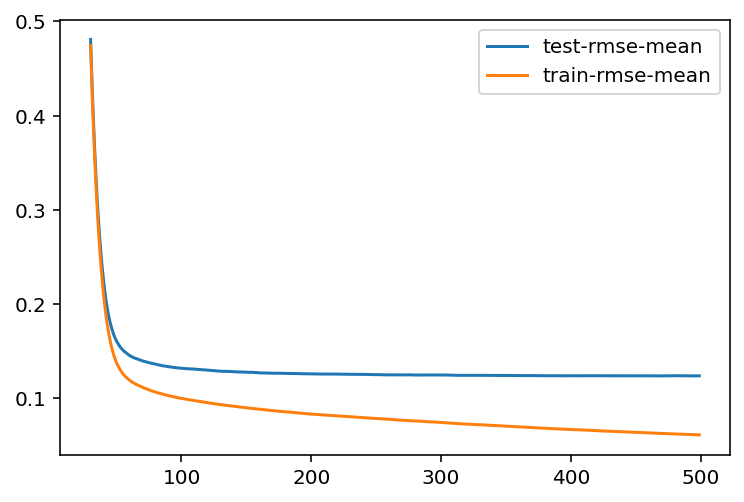

In [263]:
model.loc[30:, ["test-rmse-mean", "train-rmse-mean"]].plot()

In [266]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=360, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [267]:
np.expm1(model_xgb.predict(X_test))

array([125080.766, 156389.98 , 182810.86 , ..., 159875.02 , 116369.086,
       224669.38 ], dtype=float32)

In [268]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

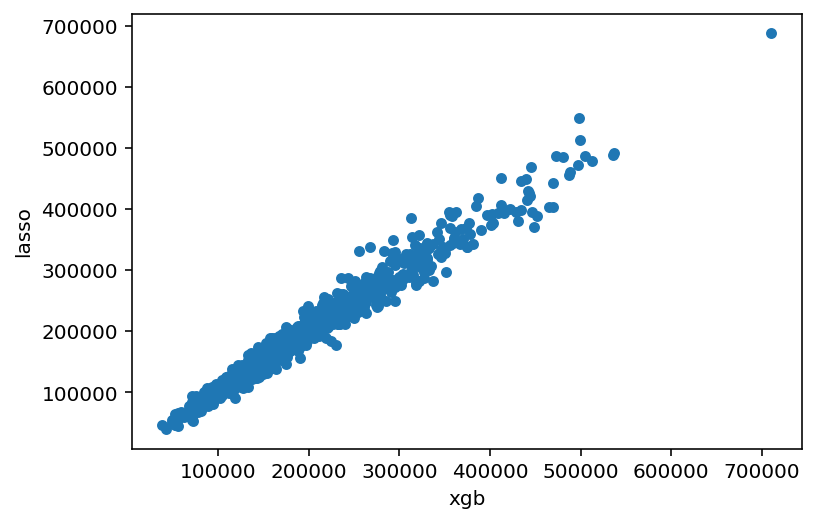

In [269]:
predictions = pd.DataFrame({"xgb": xgb_preds, "lasso": lasso_preds})
predictions.plot(x="xgb", y="lasso", kind='scatter')

In [270]:
res = pd.DataFrame({"id": test.Id, "SalePrice": lasso_preds})
res.to_csv("sub_2021_07.csv", index=False)

In [271]:
res = pd.DataFrame({"id": test.Id, "SalePrice": xgb_preds})
res.to_csv("sub_2021_07_xgb.csv", index=False)